In [53]:
# Import required packages
import numpy as np
import pandas as pd
import cv2 as cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

In [54]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf 
from tensorflow import keras 
import numpy as np 
import matplotlib.pyplot as plt 
import sys 
import time as tm

from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, MaxPool2D
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.losses import SparseCategoricalCrossentropy


## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [55]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")
train_lab=(noisy_labels).reshape(noisy_labels.shape[0],1)
train_lab_c=(clean_labels).reshape(clean_labels.shape[0],1)

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


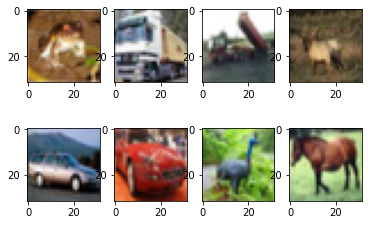

In [56]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [57]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [58]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [59]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2. Model I

In [60]:
# calculate and plot time per epoch
class timecallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.times = []
        # use this value as reference to calculate cummulative time taken
        self.timetaken = tm.time() 
    def on_epoch_end(self,epoch,logs = {}):
        self.times.append((epoch,tm.time() - self.timetaken))
    def on_train_end(self,logs = {}):
        tiii=[self.times[0][1]]
        for i in range(9):
            tiii.append(self.times[i+1][1]-self.times[i][1])  
        plt.subplots(figsize = (8,5))
        plt.subplot(111)
        plt.title("Training Time")
        plt.xlabel('Epoch')
        plt.ylabel('Time taken per epoch in seconds')
        plt.plot(tiii,color="red")
        plt.show()

In [61]:
# normalization
def normal(X):
    X=X.astype('float32')/255.00
    return X

Below is our plot for loss and accuracy code. The blue line represents model performance on the training dataset and the orange line shows the performance on the test dataset. 

In [62]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    plt.subplots(figsize = (8,10))
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='accuracy')
    plt.plot(history.history['val_loss'], color='orange', label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')


    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='accuracy')
    plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy (test)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

### Feature Detector Part
Our model involves stacking convolutional layers. Many of which are small 3x3 filters, with a LeakyReLU and then a max pooling layer. There are three of these, with increasing depth of the network from 32 to 128 for the first four blocks of the model. 

Padding is on as it helps ensure the ouput feature matches inputs. 

### Classifier Part
The classifier interprets the feature dectection and makes a prediction as to which class, in this case 1 of 10, the photo belongs. In our model, the feature extraction is flattened, using a variety of activations, down to 10 nodes for 10 classes. 

In [63]:
# define model
def clean_model1():
    #Feature Detection
    model1=Sequential()
    model1.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(32,32,3),padding='same'))
    model1.add(LeakyReLU(alpha=0.1))
    model1.add(MaxPool2D((2, 2),padding='same'))
    model1.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
    model1.add(LeakyReLU(alpha=0.1))
    model1.add(MaxPool2D(pool_size=(2, 2),padding='same'))
    model1.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
    model1.add(LeakyReLU(alpha=0.1))                  
    model1.add(MaxPool2D(pool_size=(2, 2),padding='same'))
    #Classifier
    model1.add(Flatten())
    model1.add(Dense(128, activation='linear'))
    model1.add(LeakyReLU(alpha=0.1))                  
    #model1.add(Dense(10, activation='softmax'))
    #model1.add(Flatten())
    model1.add(Dense(64, activation='relu'))
    model1.add(Dense(10))
    return model1
    

In [64]:
# fit model and compile
def fit_model(trainX,trainY,testX, testY):
    model=clean_model1()
    model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    time_callback = timecallback()
    history = model.fit(trainX,trainY,  epochs=10,callbacks=[time_callback], validation_data=(testX, testY))
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)
    return model
    

In [65]:
# prepare data for model1

trainX, testX, trainY, testY = train_test_split(imgs, train_lab, 
                                                           test_size=0.2, random_state=13)    #get validation set 
# normalize the data
trainX = normal(trainX)
testX = normal(testX)

In [66]:
model1=fit_model(trainX,trainY,testX, testY)

Epoch 1/10
1250/1250 [==============================] - 53s 42ms/step - loss: 2.2793 - accuracy: 0.1427 - val_loss: 2.2533 - val_accuracy: 0.1734
Epoch 2/10
1250/1250 [==============================] - 52s 42ms/step - loss: 2.2396 - accuracy: 0.1921 - val_loss: 2.2321 - val_accuracy: 0.2027
Epoch 3/10
1250/1250 [==============================] - 52s 42ms/step - loss: 2.2094 - accuracy: 0.2188 - val_loss: 2.2223 - val_accuracy: 0.2190
Epoch 4/10
1250/1250 [==============================] - 52s 42ms/step - loss: 2.1780 - accuracy: 0.2451 - val_loss: 2.2202 - val_accuracy: 0.2281
Epoch 5/10
1250/1250 [==============================] - 53s 42ms/step - loss: 2.1364 - accuracy: 0.2686 - val_loss: 2.2209 - val_accuracy: 0.2306
Epoch 6/10
 426/1250 [=========>....................] - ETA: 32s - loss: 2.0675 - accuracy: 0.2985

Above is our plot for loss and accuracy code. The blue line represents model performance on the training dataset and the orange line shows the performance on the test dataset. This graph is concerning as the test dataset accuracy falls while the training accuracy rises. This could be a sign of overfitting which we need to counter. 

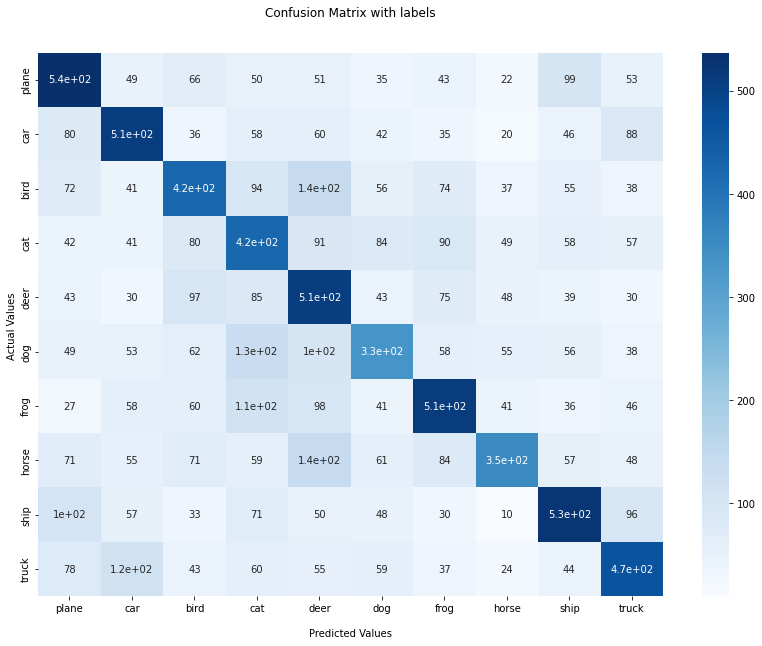

In [ ]:
labels_pred = np.argmax(model1.predict(normal(imgs[:10000])), axis = 1)
cf_matrix = confusion_matrix(clean_labels, labels_pred)

plt.figure(figsize=(14, 10))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)

## Display the visualization of the Confusion Matrix.
plt.show()


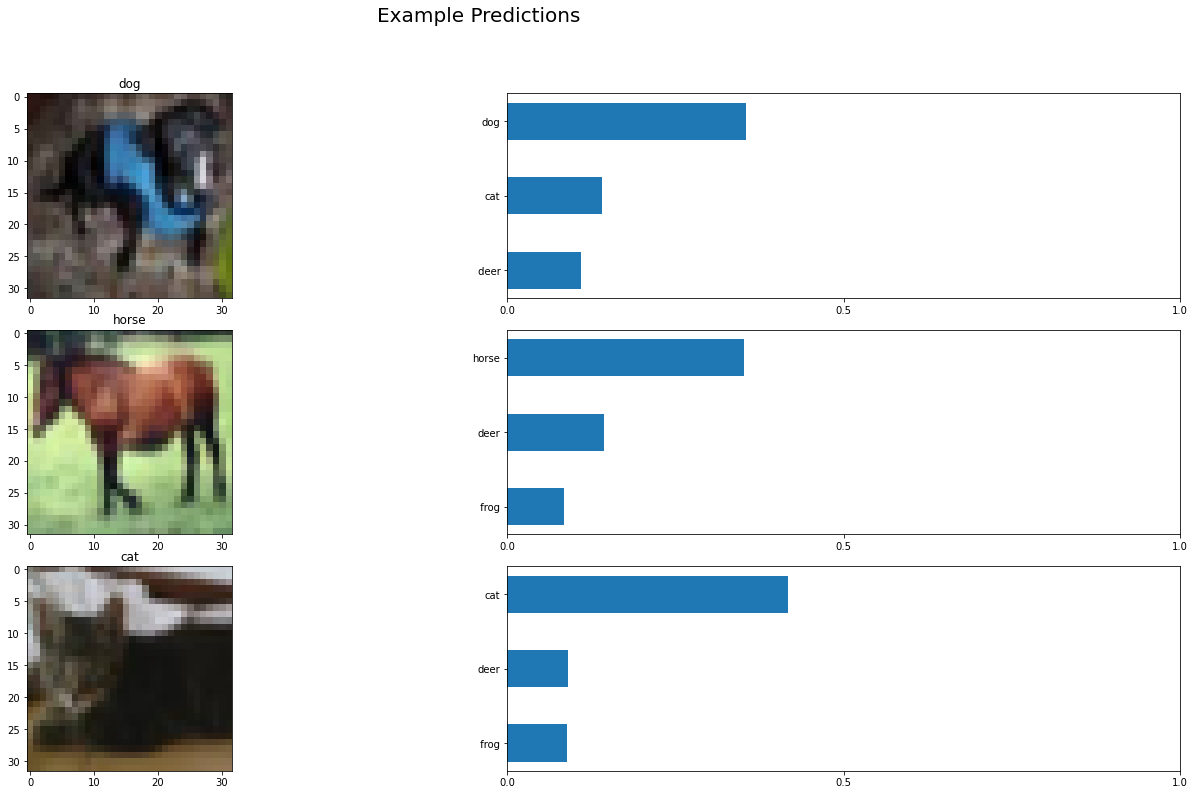

In [ ]:
np.argmin(np.diagonal(cf_matrix))

fig, axies = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
fig.tight_layout()
fig.suptitle('Example Predictions', fontsize=20, y=1.1)

n_predictions = 3
margin = 0.05
ind = np.arange(n_predictions)
width = (1. - 2. * margin) / n_predictions
# consider 3 most common prediction mistake for the actual picture that has badest prediction performance(class bad)
n_top=3 
j=0
#,cf_matrix= pd.DataFrame(cf_matrix)
for i in np.diagonal(cf_matrix).argsort()[:n_predictions]:
    #cf_matrix0=cf_matrix.drop(i,axis=1)
    h=[np.where(clean_labels==[i])][0][0][0]
    axies[j][0].imshow(imgs[h]/255)
    axies[j][0].set_title(classes[i])
    pre=" "
    for bad in cf_matrix[i,].argsort()[::-1][:n_top][::-1]:
        pre=pre+(classes[bad])+","
    pre=pre.split(',')
    axies[j][1].barh(pre[:n_top],(np.sort(cf_matrix[i,])[-n_top:])/cf_matrix[i,].sum(),0.5)
    axies[j][1].set_yticks(pre[:n_top])
   # axies[j][1].set_yticklabels()
    axies[j][1].set_xticks([0, 0.5, 1.0])
    j=j+1
    





In [ ]:
model1.save('model1.h5')

In [ ]:
# calls from above
def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    image = tf.reshape(image, ((1,) + image.shape))
    image = tf.cast(image, dtype='float32')/255.0
    
    # Rather than use the model stored in memory, we load the saved, trained model so it doesn't have 
    # to be trained every time you want to run predictions
    model1 = load_model('model1.h5')

    prediction = np.argmax(model1.predict(image))
    return prediction   


### 2.3. Model II

## Model2

Without using data augmentation

Epoch 1/10
250/250 [==============================] - 11s 44ms/step - loss: 1.8614 - accuracy: 0.3090 - val_loss: 1.4972 - val_accuracy: 0.4475
Epoch 2/10
250/250 [==============================] - 11s 43ms/step - loss: 1.4362 - accuracy: 0.4717 - val_loss: 1.4120 - val_accuracy: 0.4750
Epoch 3/10
250/250 [==============================] - 10s 42ms/step - loss: 1.2440 - accuracy: 0.5480 - val_loss: 1.2701 - val_accuracy: 0.5315
Epoch 4/10
250/250 [==============================] - 11s 43ms/step - loss: 1.0443 - accuracy: 0.6201 - val_loss: 1.1237 - val_accuracy: 0.5975
Epoch 5/10
250/250 [==============================] - 10s 42ms/step - loss: 0.8812 - accuracy: 0.6886 - val_loss: 1.0581 - val_accuracy: 0.6310
Epoch 6/10
250/250 [==============================] - 10s 42ms/step - loss: 0.7169 - accuracy: 0.7441 - val_loss: 1.0987 - val_accuracy: 0.6325
Epoch 7/10
250/250 [==============================] - 11s 43ms/step - loss: 0.5610 - accuracy: 0.8006 - val_loss: 1.1345 - val_accuracy:

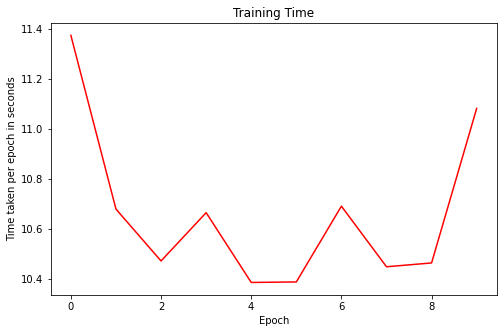

> 64.300


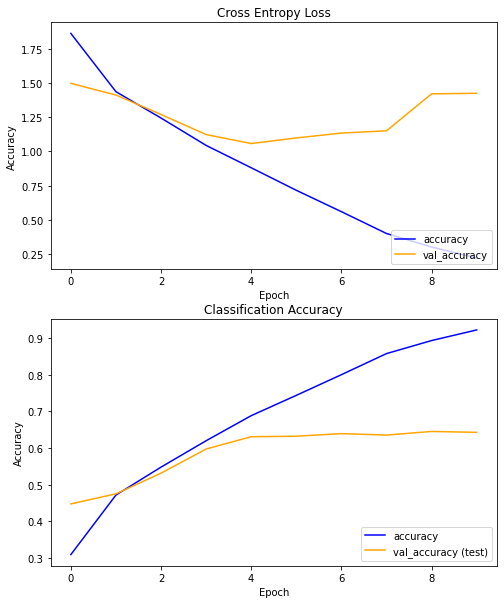

[1.4245840311050415, 0.6430000066757202]

In [ ]:
trainX, testX, trainY, testY = train_test_split(imgs[:10000], train_lab_c, 
                                                           test_size=0.2, random_state=13)    #get validation set     
    # normalize the data
trainX= normal(trainX) 
testX = normal(testX)

model2_clean=fit_model(trainX,trainY,testX, testY)
model2_clean.evaluate(testX, testY, verbose=0)

In [ ]:
# predict for noisy labels and combine clean data and predicted data
a=normal(imgs[10000:])
b=normal(imgs[:10000])

y_pred_val=model2_clean.predict(a)
y_pred_class=[np.argmax(element) for element in y_pred_val]
p=np.array(y_pred_class)
train_lab_p=(p).reshape(p.shape[0],1)
train_lab_n=np.concatenate((trainY,train_lab_p),axis=0)
train_X_n=np.concatenate((trainX,a),axis=0)
train_lab_all=np.concatenate((train_lab_c,train_lab_p),axis=0)
train_X_all=np.concatenate((b,a),axis=0)
train_X2,test_X2,train_Y2,test_Y2=train_test_split(train_X_all, train_lab_all, 
                                                           test_size=0.2, random_state=13)   



In [ ]:
model2=fit_model(train_X2, train_Y2,test_X2, test_Y2)

Epoch 1/10
 321/1250 [======>.......................] - ETA: 35s - loss: 1.7490 - accuracy: 0.3503

KeyboardInterrupt: 

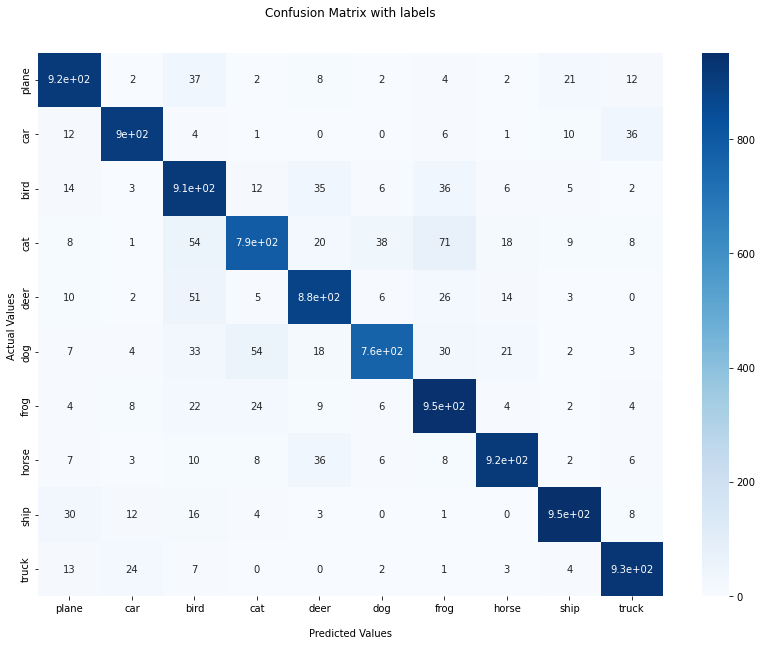

In [ ]:
labels_pred = np.argmax(model2.predict(normal(imgs[:10000])), axis = 1)
cf_matrix = confusion_matrix(clean_labels, labels_pred)

plt.figure(figsize=(14, 10))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)

## Display the visualization of the Confusion Matrix.
plt.show()

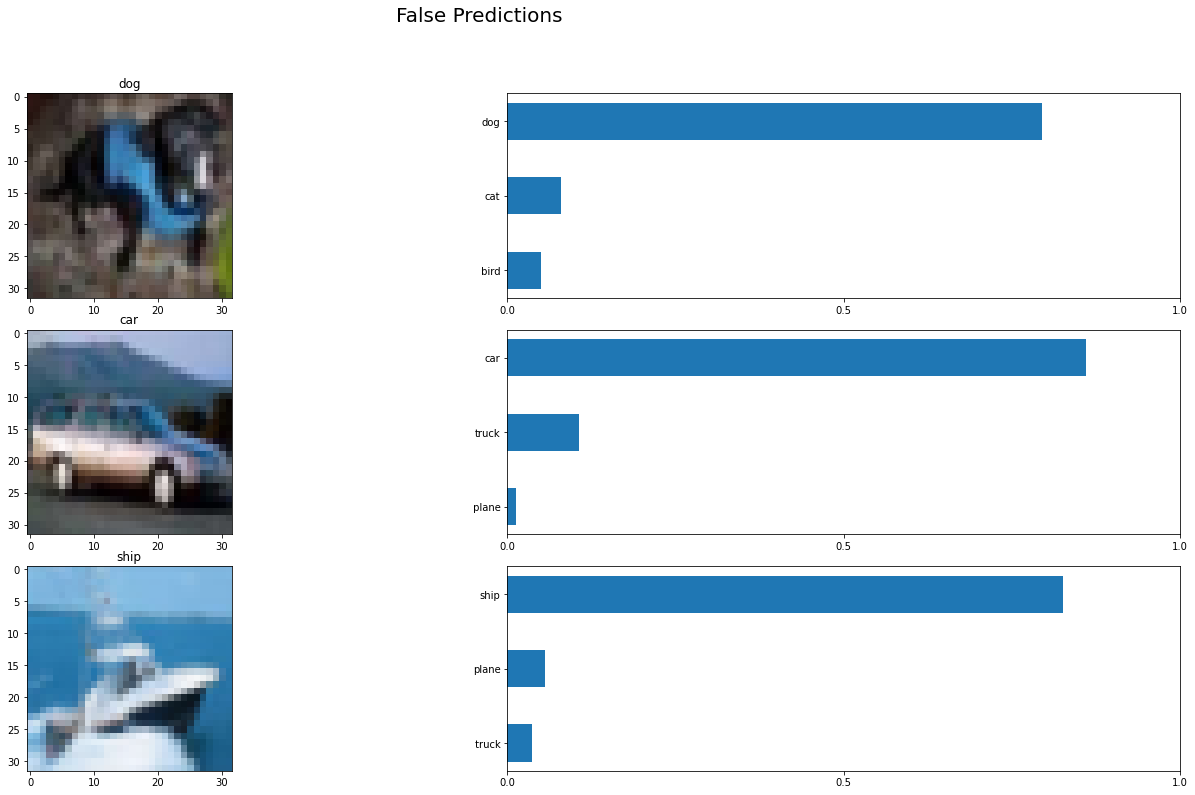

In [ ]:
np.argmin(np.diagonal(cf_matrix))

fig, axies = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
fig.tight_layout()
fig.suptitle('False Predictions', fontsize=20, y=1.1)

n_predictions = 3
margin = 0.05
ind = np.arange(n_predictions)
width = (1. - 2. * margin) / n_predictions
# consider 3 most common prediction mistake for the actual picture that has badest prediction performance(class bad)
n_top=3 
j=0
#,cf_matrix= pd.DataFrame(cf_matrix)
for i in np.diagonal(cf_matrix).argsort()[:n_predictions]:
    #cf_matrix0=cf_matrix.drop(i,axis=1)
    h=[np.where(clean_labels==[i])][0][0][0]
    axies[j][0].imshow(imgs[h]/255)
    axies[j][0].set_title(classes[i])
    pre=" "
    for bad in cf_matrix[i,].argsort()[::-1][:n_top][::-1]:
        pre=pre+(classes[bad])+","
    pre=pre.split(',')
    axies[j][1].barh(pre[:n_top],(np.sort(cf_matrix[i,])[-n_top:])/cf_matrix[i,].sum(),0.5)
    axies[j][1].set_yticks(pre[:n_top])
   # axies[j][1].set_yticklabels()
    axies[j][1].set_xticks([0, 0.5, 1.0])
    j=j+1
    



In [ ]:
#save the trained model to a file
model2.save('model2.h5')

In [ ]:
# Prediction 
def model_II(image):
    image = tf.reshape(image, ((1,) + image.shape))
    image = tf.cast(image, dtype='float32')/255.0

    # Rather than use the model stored in memory, we load the saved, trained model so it doesn't have 
    # to be trained every time you want to run predictions
    model2 = load_model('model2.h5')
    prediction = np.argmax(model2.predict(image))
    return prediction   

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [ ]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [ ]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

ValueError: Found input variables with inconsistent numbers of samples: [50000, 10]

In [ ]:
# model2 - clean data test
# you can skip this
start_time = tm.time()
evaluation(model_II,test_Y2, test_X2)
print(tm.time() - start_time)

NameError: name 'evaluation' is not defined

The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.